# read_bruker

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# initialise plotly in offline mode
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
import os
import errno
import datetime
import tempfile
from distutils.dir_util import copy_tree

import nmrglue as ng

import pylab as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from batman import PyBatman, PyBatmanOptions, Database, Metabolite

In [3]:
import warnings
warnings.filterwarnings("ignore") # supress annoying warnings

In [4]:
input_dirs = [
    '/home/rstudio/NMR/Maria_25_07_2016/data/bruker/normal_serum/Maria_serum_b_1',
]
pattern = 'cpmg'
working_dir = 'test/temp'

In [5]:
# see http://stackoverflow.com/questions/3925096/how-to-get-only-the-last-part-of-a-path-in-python
labels = []
for input_dir in input_dirs:
    last = os.path.basename(os.path.normpath(input_dir))
    labels.append(last)

In [6]:
def get_matching_paths(input_dirs, pattern):

    matching = []
    for input_dir in input_dirs:

        # find all the child directories
        sub_dirs = [os.path.join(input_dir, x) for x in os.listdir(input_dir)]
        for path in sub_dirs:

            # check the pulse program if it exists
            if os.path.isdir(path):
                pp = os.path.join(path, 'pulseprogram')
                if os.path.isfile(pp): # if exists

                    # if it contains the pattern then store this path
                    with open(pp, 'r') as f:
                        head = [next(f) for x in xrange(2)]
                        if pattern in head[1]:
                            matching.append(path)

    return matching

In [7]:
# extract spectra name
matching = get_matching_paths(input_dirs, pattern)
print "Found spectra matching pattern '%s':" % pattern
for s in matching:
    print '-', s

Found spectra matching pattern 'cpmg':
- /home/rstudio/NMR/Maria_25_07_2016/data/bruker/normal_serum/Maria_serum_b_1/422


In [8]:
def _mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
# create working directory
_mkdir_p(working_dir)
prefix = datetime.datetime.now().strftime("%G%m%d_%H%M%S_")
temp_dir = tempfile.mkdtemp(prefix=prefix, dir=working_dir)
batman_dir = os.path.join(temp_dir, 'runBATMAN')
batman_input = os.path.join(batman_dir, 'BatmanInput')
batman_output = os.path.join(batman_dir, 'BatmanOutput')
_mkdir_p(batman_input)
_mkdir_p(batman_output)
print 'Working directory =', working_dir
print '- batman_input =', batman_input
print '- batman_output =', batman_output

Working directory = test/temp
- batman_input = test/temp/20161028_213221_S0D3z8/runBATMAN/BatmanInput
- batman_output = test/temp/20161028_213221_S0D3z8/runBATMAN/BatmanOutput


In [9]:
def _prepare_data(matching, data_dir):
    out_dirs = []
    for f in range(len(matching)):
        path = matching[f]
        out_dir = os.path.join(data_dir, 'pdata', str(f))
        _mkdir_p(out_dir)
        print 'Copied spectra to', out_dir
        copy_tree(path, out_dir)
        out_dirs.append(out_dir)
    return out_dirs

In [12]:
batman_data = os.path.join(batman_dir, 'data')
temp_data = _prepare_data(matching, batman_data)

Copied spectra to test/temp/20161028_213221_S0D3z8/runBATMAN/data/pdata/0


In [10]:
def _load_single_spectra(spectra_dir):

    p_data = os.path.join(spectra_dir, 'pdata/1')
    print 'Processing', p_data

    dic, data = ng.bruker.read_pdata(p_data)
    udic = ng.bruker.guess_udic(dic, data)
    uc = ng.fileiobase.uc_from_udic(udic, 0)
    # print dic.keys(), udic.keys()
    # print uc.ppm_limits()
    # print uc.ppm_scale()
    # print len(uc.ppm_scale())

    x = []
    y = []
    for ppm in uc.ppm_scale():
        x.append(ppm)
        y.append(data[uc(ppm, 'ppm')])
    x = np.array(x)
    y = np.array(y)

    return x, y

In [11]:
def _load_data_with_nmrglue(input_dirs):
    spectra = []
    for input_dir in input_dirs:
        x, y = _load_single_spectra(input_dir)
        spectra.append(y)
    combined = [x]
    combined.extend(spectra)
    combined = np.array(combined).transpose()
    print 'Loaded', combined.shape
    return combined

In [13]:
spectra = _load_data_with_nmrglue(temp_data)

Processing test/temp/20161028_213221_S0D3z8/runBATMAN/data/pdata/0/pdata/1
Getting from raw_dic
FQ3LIST ------ 
DSPFVS ------ 21
GPNAM ------ ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
VALIST ------ 
SPNAM ------ ['', 'Gaus1_270.1000', 'Gaus1_180r.1000', '', '', 'Sinc1.1000', 'Squa100.1000', '', 'Squa100.1000', '', 'Sinc1.1000', 'Sinc1.1000', '', '', '', '', '', '', '', 'Sinc1.1000', 'Sinc1.1000', 'Sinc1.1000', 'Sinc1.1000', '', '', '', '', '', '', 'Crp60,20,20.10', 'Bip720,50,20.1', '', '', '', 'Gaus1_180r.1000', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
PHP ------ 1
EXP ------ hS_LMWM_5mm_130430
O8 ------ 2822.11
O7 ------ 2822.11
O6 ------ 2822.11
O5 ------ 2822.11
NusTD ------ 0
O3 ------ 2822.11
O2 ------ 2822.11
O1 ------ 2821.20999998
TE3 ------ 0
FQ7LIST ------ 
ANAVPT ------ -1
FQ1LIST ------ 
SPW ------ [0, 4.7352e-06,

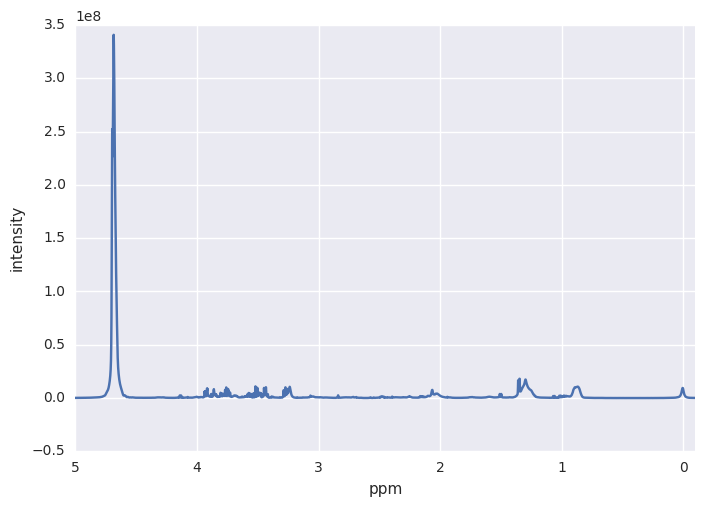

In [14]:
def plot_spectra(spectra):
    plt.figure()
    x = spectra[:, 0]
    for n in range(1, spectra.shape[1]):
        y = spectra[:, n]
        plt.plot(x, y)
    plt.xlim([-0.1, 5])
    plt.gca().invert_xaxis()
    plt.xlabel('ppm')
    plt.ylabel('intensity')

plot_spectra(spectra)